In [116]:
import pandas as pd
import glob
import os
import re
import sys
import ast
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [478]:
#read files and save the labels to lists
def readFiles(dir):
    dataAll_df = pd.read_csv(dir,index_col=None, header=0)
    utt = dataAll_df['utt'].to_list()
    utt = [i.strip() for i in utt]
    tokens = dataAll_df['tokenized'].to_list()
    clean_tokens = [ast.literal_eval(i) for i in tokens]
    return list(zip(utt, clean_tokens)), utt

In [599]:
Odin, Odin_utt = readFiles("metadata2tokenzied.csv")
Golden, Golden_utt = readFiles("cleanAnnotation.csv")

In [600]:
#select the Vers-3 data from Odin(Vers-6)
OdinDict = {}
for i in Odin:
    OdinDict[i[0]] = i[1]
selected_Odin = []
for i in range(len(Golden_utt)):
    if Golden_utt[i] in OdinDict:
        selected_Odin.append((Golden_utt[i],OdinDict[Golden_utt[i]]))
Odin = selected_Odin

In [601]:
# get the label tokens
# duplicated tokens in the same sentence are removed
OdinTokens = [list(set(i[1])) for i in Odin]
GoldenTokens = [list(set(i[1])) for i in Golden]

In [602]:
###################
##### Step 1 ######
###################
# Transform the original form to single label form: 

OT = []
GT = []
for i in range(len(OdinTokens)):
    sent_idx = i
    len1,len2 = len(OdinTokens[i]),len(GoldenTokens[i])
    # padding 0 to shorter lists
    if len1 > len2:
        r2 = GoldenTokens[i] + (len1-len2) * [0]
        r1 = OdinTokens[i]
    elif len2 > len1:
        r1 = OdinTokens[i] + (len2-len1) * [0]
        r2 = GoldenTokens[i]
    else:
        r1,r2 = OdinTokens[i], GoldenTokens[i]
    # deal with overlap
    # can also deal with duplicates. Since no duplication now, overlap[j] is always 1
    overlap = Counter(r1) & Counter(r2)
    for j in overlap:
        OT += [sent_idx, j] * overlap[j]
        GT += [sent_idx, j] * overlap[j]
        for n in range(overlap[j]):
            r1.remove(j)
            r2.remove(j)
    for k in r1:
        OT +=[sent_idx, k]
    for l in r2:
        GT +=[sent_idx, l]

In [603]:
# create a nested list, shown in a dataframe
count = 1
entry_idx, sent_idx, OT2, GT2 = [], [], [], []
for i in range(0,len(OT), 2):
    entry_idx.append(count)
    sent_idx.append(OT[i])
    OT2.append(OT[i+1])
    GT2.append(GT[i+1])
    count += 1
original = list(zip(entry_idx, sent_idx, OT2, GT2))
original_df = pd.DataFrame(original, columns=["entry_idx", "sent_idx", "odin_extractions", "annotation"])
original_df

,entry_idx,sent_idx,odin_extractions,annotation
0,1,0,0,0
1,2,1,0,0
2,3,2,5,5
3,4,2,7,7
4,5,2,20,20
...,...,...,...,...
6174,6175,3681,0,13
6175,6176,3682,0,19
6176,6177,3683,0,3
6177,6178,3684,6,6


In [604]:
###################
##### Step 2 ######
###################
# Create diff tables and evaluate:

# label dictionaries
labels = {'0':0,
"CriticalVictim":1,
'Victim':2,
'Room':3,
'Engineer':4,
'Transporter':5,
'Medic':6,
'Rubble':7,
'MarkerBlock':8,
'Meeting':9,
'Move':10,
'Precedence':11,
'RescueInteractions':12,
'KnowledgeSharing':13,
'ReportLocation':14,
'Search':15,
'HelpRequest':16,
'Question':17,
'YesNoQuestion':18,
'Instruction':19,
'Plan':20
}

reverseLabels = {}
for key,value in labels.items():
    reverseLabels[value] = key

groupedLabels = {
    0: "0",
    1: "Token Labels",
    2: "Event Labels"
}

In [605]:
#Read Diff evaluation
def readEval(dir):
    dataAll_df = pd.read_csv(dir,index_col=None, header=0)
    eval = dataAll_df.iloc[:, 3].to_list()
    return eval

In [606]:
# get diff files with index
def getDiff(label_token):
    res = []
    for i in range(len(OT2)):
        ot, gt = OT2[i], GT2[i]
        if label_token in [ot, gt] and ot != gt:
            res.append([entry_idx[i],sent_idx[i], ot, gt])
    print("number of diff for", reverseLabels[label_token], "label:", len(res))
    return res

In [607]:
# add eval to diff
diffAll = {}
for i in range(1,21):
    diff = getDiff(i)
    eval = readEval("diff_eval/" + reverseLabels[i] + "_Diff.csv")
    diff_dict = {}
    for j in range(len(eval)):
        diff_dict[diff[j][0]] = diff[j][1:] + [eval[j]]
    diffAll[i] = diff_dict

number of diff for CriticalVictim label: 168
number of diff for Victim label: 200
number of diff for Room label: 309
number of diff for Engineer label: 36
number of diff for Transporter label: 47
number of diff for Medic label: 19
number of diff for Rubble label: 24
number of diff for MarkerBlock label: 53
number of diff for Meeting label: 19
number of diff for Move label: 260
number of diff for Precedence label: 123
number of diff for RescueInteractions label: 73
number of diff for KnowledgeSharing label: 237
number of diff for ReportLocation label: 110
number of diff for Search label: 55
number of diff for HelpRequest label: 119
number of diff for Question label: 110
number of diff for YesNoQuestion label: 155
number of diff for Instruction label: 321
number of diff for Plan label: 379


In [608]:
###################
##### Step 3 ######
###################

new_lines = []
renewed = []
for i in range(len(original)):
    entry_idx, sent_idx, OT2, GT2 = original[i]
    if OT2 != GT2:
        if OT2 == 0:
            EO = bool(diffAll[GT2][entry_idx][3])
            EG = not EO
        elif GT2 == 0:
            EO = bool(diffAll[OT2][entry_idx][3])
            EG = not EO
        else:
            eval1, eval2 = diffAll[OT2][entry_idx][3], diffAll[GT2][entry_idx][3]
            if eval1 and eval2: EO, EG = True, False
            elif (not eval1) and (not eval2): EO, EG = False, True
            elif eval1 and (not eval2): EO, EG = True, True
            elif (not eval1) and eval2: EO, EG = False, False
        if EO and (not EG): GT2 = OT2
        elif (not EO) and (not EG): GT2 = 0
        elif EO and EG: 
            new_lines.append([count+entry_idx, sent_idx, 0, GT2])
            GT2 = OT2
    renewed.append([entry_idx, sent_idx, OT2, GT2])

In [609]:
###################
##### Step 4 ######
###################

# clean the tabel

newData = renewed + new_lines

cleanOT = {}
cleanGT = {}
for i in newData:
    sent_idx, OT, GT = i[1:]
    if sent_idx in cleanOT:
        if OT + GT != 0:
            cleanOT[sent_idx] += [OT]
            cleanGT[sent_idx] += [GT]
    else:
        cleanOT[sent_idx] = [OT]
        cleanGT[sent_idx] = [GT]

In [610]:
###################
##### Step 5 ######
###################

#convert label tokens to a single list
def singleList(testTokens, GoldenTokens):
    TT = []
    GT = []
    for i in range(len(testTokens)):
        len1,len2 = len(testTokens[i]),len(GoldenTokens[i])
        #padding 0 to shorter lists
        if len1 > len2:
            r2 = GoldenTokens[i] + (len1-len2) * [0]
            r1 = testTokens[i]
        elif len2 > len1:
            r1 = testTokens[i] + (len2-len1) * [0]
            r2 = GoldenTokens[i]
        else:
            r1,r2 = testTokens[i], GoldenTokens[i]
        #deal with overlap
        overlap = Counter(r1) & Counter(r2)
        for j in overlap:
            TT += [j] * overlap[j]
            GT += [j] * overlap[j]
            for n in range(overlap[j]):
                r1.remove(j)
                r2.remove(j)
        for k in r1:
            TT.append(k)
        for l in r2:
            GT.append(l)
    return GT,TT

In [611]:
newOdin = list(cleanOT.values())
newGolden = list(cleanGT.values())

In [ ]:
##########################
# Rule-baseed evaluation #
##########################

GT, OT = singleList(newOdin, newGolden)

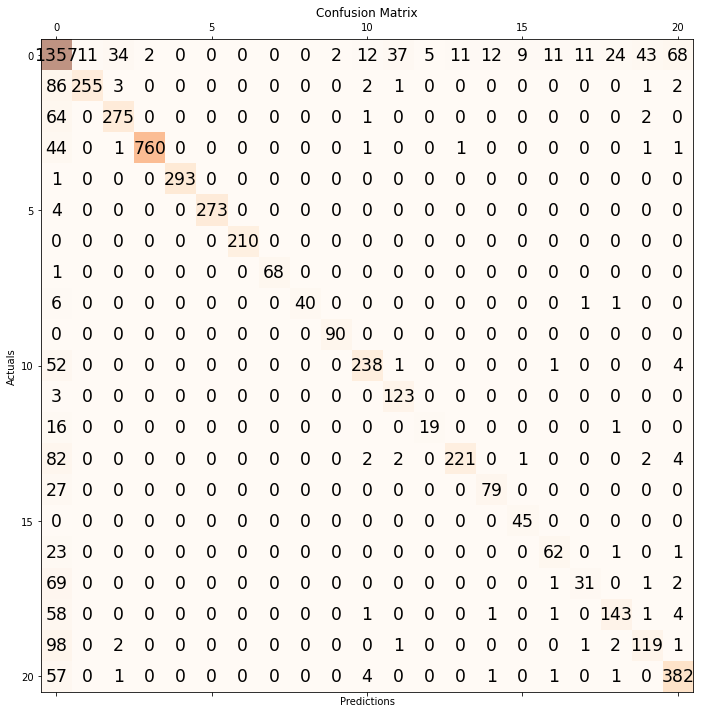

In [542]:
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=GT, y_pred=OT)

fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

In [543]:
def printOverall(GT, TT):
    overall = metrics.classification_report(GT, TT, digits=3, zero_division=1)
    results = []
    lines = overall.strip().split("\n")
    headers = lines[0].split("  ")
    headers = [i.strip() for i in headers]
    headers.remove("")
    lines.remove("")
    lines =lines[-3:]
    for line in lines:
        scores = line.strip().split("     ")
        scores = [i.strip() for i in scores]
        if "" in scores:
            scores.remove("")
            scores.remove("")
        results.append(scores)
    headers = ["      "] + headers
    overall_df = pd.DataFrame(results, columns=headers)
    return overall_df

In [544]:
def printIndividual(GT, TT):
     overall = metrics.classification_report(GT, TT, digits=3, zero_division=1)
     results = []
     lines = overall.strip().split("\n")
     headers = lines[0].split("  ")
     headers = [i.strip() for i in headers]
     headers.remove("")
     lines.remove("")
     lines = lines[1:22]
     for line in lines:
          scores = line.strip().split("     ")
          scores = [i.strip() for i in scores]
          results.append([reverseLabels[int(scores[0])]] + scores[1:])   
     headers = ["group"] + headers
     individual_df = pd.DataFrame(results, columns=headers)
     return individual_df

In [583]:
def printGrouped(GolkenToken, TestToken):
    #token event groups
    def splitTokenEvent(data):
        token, event = [], []
        for i in range(len(data)):
            t = list(set(data[i]) & set(range(10)))
            e = list(set(data[i]) & {0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20})
            if t:
                token.append(t)
            else:
                token.append([0])
            if e:
                event.append(e)
            else:
                event.append([0])
        return token, event
    TTToken, TTEvent = splitTokenEvent(TestToken)
    GTToken, GTEvent = splitTokenEvent(GolkenToken)

    GTToken2, TTToken2 = singleList(TTToken, GTToken)
    GTEvent2, TTEvent2 = singleList(TTEvent, GTEvent)

    tokenScore = metrics.classification_report(GTToken2, TTToken2, digits=3)
    eventScore = metrics.classification_report(GTEvent2, TTEvent2, digits=3)
    
    #print
    
    def printScore(scoreMatrix):
        results = []
        lines = scoreMatrix.strip().split("\n")
        headers = lines[0].split("  ")
        headers = [i.strip() for i in headers]
        headers.remove("")
        lines.remove("")
        lines =lines[-3:]
        for line in lines:
            scores = line.strip().split("     ")
            scores = [i.strip() for i in scores]
            if "" in scores:
                scores.remove("")
                scores.remove("")
            results.append(scores)
        headers = ["      "] + headers
        grouped_df = pd.DataFrame(results, columns=headers)
        return grouped_df
    print("The overall score of the Token label group:") 
    print(printScore(tokenScore))
    print("The overall score of the Event label group:") 
    print(printScore(eventScore))

In [411]:
printIndividual(GT, OT)

,group,precision,recall,f1-score,support
0,0,0.663,0.823,0.734,1649
1,CriticalVictim,0.959,0.729,0.828,350
2,Victim,0.870,0.804,0.836,342
3,Room,0.997,0.939,0.968,809
4,Engineer,1.000,0.997,0.998,294
5,Transporter,1.000,0.986,0.993,277
6,Medic,1.000,1.000,1.000,210
7,Rubble,1.000,0.986,0.993,69
8,MarkerBlock,1.000,0.833,0.909,48
9,Meeting,0.978,1.000,0.989,90


In [584]:
printGrouped(newGolden,newOdin)

The overall score of the Token label group:
                precision recall f1-score support
0      accuracy                     0.943    4875
1     macro avg     0.972  0.925    0.946    4875
2  weighted avg     0.945  0.943    0.942    4875
The overall score of the Token label group:
                precision recall f1-score support
0      accuracy                     0.820    4381
1     macro avg     0.811  0.728    0.754    4381
2  weighted avg     0.821  0.820    0.814    4381


In [453]:
#######################
# zeroshot evaluation #
#######################
######## Static #######
#######################

# rerun from begining and skip the rule-based evaluation

Static, Static_utt = readFiles("zeroshot_static.csv")
StaticTokens = [i[1] for i in Static]
GT_S, ST = singleList(StaticTokens, newGolden)


In [454]:
printOverall(GT_S, ST)

,,precision,recall,f1-score,support
0,accuracy,,,0.096,36463
1,macro avg,0.124,0.706,0.184,36463
2,weighted avg,0.023,0.096,0.034,36463


In [598]:
printGrouped(newGolden, StaticTokens)

The overall score of the Token label group:
                precision recall f1-score support
0      accuracy                     0.005   14130
1     macro avg     0.019  0.002    0.002   14130
2  weighted avg     0.148  0.005    0.010   14130
The overall score of the Token label group:
                precision recall f1-score support
0      accuracy                     0.001   19337
1     macro avg     0.023  0.001    0.000   19337
2  weighted avg     0.245  0.001    0.003   19337


In [455]:
printIndividual(GT_S, ST)

,group,precision,recall,f1-score,support
0,0,0.000,0.000,0.000,31980
1,CriticalVictim,0.216,0.823,0.342,350
2,Victim,0.228,0.813,0.356,342
3,Room,0.251,0.889,0.391,809
4,Engineer,0.746,0.810,0.777,294
5,Transporter,0.089,1.000,0.164,277
6,Medic,0.186,0.733,0.296,210
7,Rubble,0.134,0.783,0.229,69
8,MarkerBlock,0.017,1.000,0.033,48
9,Meeting,0.030,0.989,0.059,90


In [469]:
#######################
# zeroshot evaluation #
#######################
####### Dynamic #######
#######################

# rerun from begining and skip the rule-based evaluation and Zeroshot Static

Dynamic, Dynamic_utt = readFiles("zeroshot_dynamic.csv")
DynamicTokens = [i[1] for i in Dynamic]
GT_D, DT = singleList(DynamicTokens, newGolden)

In [472]:
printOverall(GT_D, DT)

,,precision,recall,f1-score,support
0,accuracy,,,0.472,6336
1,macro avg,0.401,0.379,0.333,6336
2,weighted avg,0.528,0.472,0.450,6336


In [612]:
printGrouped(newGolden, DynamicTokens)

The overall score of the Token label group:
                precision recall f1-score support
0      accuracy                     0.510    4662
1     macro avg     0.440  0.262    0.274    4662
2  weighted avg     0.527  0.510    0.466    4662
The overall score of the Token label group:
                precision recall f1-score support
0      accuracy                     0.515    4307
1     macro avg     0.143  0.153    0.127    4307
2  weighted avg     0.451  0.515    0.459    4307


In [477]:
printIndividual(GT_D, DT)

,group,precision,recall,f1-score,support
0,0,0.631,0.753,0.687,1853
1,CriticalVictim,0.751,0.423,0.541,350
2,Victim,0.691,0.561,0.619,342
3,Room,0.572,0.286,0.381,809
4,Engineer,0.957,0.609,0.744,294
5,Transporter,0.303,0.888,0.451,277
6,Medic,0.696,0.567,0.625,210
7,Rubble,0.950,0.551,0.697,69
8,MarkerBlock,0.272,0.708,0.393,48
9,Meeting,0.279,0.856,0.421,90
